# Import libraries

In [ ]:
import requests
import nltk
import spacy
import tensorflow as tf
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import numpy as np
from tensorflow.keras import utils

# Load data

In [ ]:
import requests
import os

# 10.5281/zenodo.17054610
record_id = '17054610'
filename_to_download = 'vk_posts_balanced.xlsx'

api_url = f'https://zenodo.org/api/records/{record_id}'

try:
    print(f"Searching for file '{filename_to_download}' in Zenodo repository with ID: {record_id}...")

    response = requests.get(api_url)
    response.raise_for_status()
    data = response.json()

    file_url = None
    for file in data.get('files', []):
        if file.get('key') == filename_to_download:
            file_url = file.get('links', {}).get('self')
            break

    if file_url:
        print(f"File '{filename_to_download}' found. Starting download...")

        file_response = requests.get(file_url, stream=True)
        file_response.raise_for_status()

        # Save the file to the current directory
        with open(filename_to_download, 'wb') as f:
            for chunk in file_response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"File '{filename_to_download}' downloaded successfully.")
    else:
        print(f"File '{filename_to_download}' not found in the repository.")

except requests.exceptions.RequestException as e:
    print(f"An error occurred while accessing Zenodo: {e}")

posts = pd.read_excel('vk_posts_balanced.xlsx')
posts.drop(posts.index[posts['class']=='1,2,4'], inplace = True)
posts.reset_index(drop=True, inplace=True)

In [ ]:
posts["class"].values

array([2, 2, 2, ..., 2, 2, 1])

In [ ]:
nb_classes = 5
posts.dropna()
posts['text'] = posts['text'].astype(str)

# Dividing the data into training and test sets

In [ ]:
# Auxiliary function of dividing dataframes
def split_dataframe(dataframe, test_proportion):
    total_size = len(dataframe)
    test_size = int(total_size * test_proportion)
    indices = np.arange(total_size)
    np.random.shuffle(indices)
    train_indices = indices[0:total_size-test_size]
    test_indices = indices[total_size - test_size:]
    return dataframe.iloc[train_indices], dataframe.iloc[test_indices]
train, test = split_dataframe(posts, 0.3)
train

,text,class
1530,Ролл за каждый отзыв! 🔥 \n \nДрузья! Мы дарим ...,2
522,"Кешбэк, который радует!\n💸 С каждого заказа во...",3
223,Тройной кэшбэк 🤩\n\n«В рот — и точка!» — это в...,3
549,"Работа работой, а обед по расписанию💪 \n \nОфо...",2
1031,👇 ДАРИМ НАБОР РОЛЛОВ 👇\n\nПросто ставь лайк и ...,2
...,...,...
286,🌿Лодочки из кабачков с курицей\n\n.\n.\n.\nАвт...,0
1730,Розыгрыш трех вкусняшек от Кубы уже тут! 🍕❤💥 \...,2
668,"💥 Новая точка на Салютной, 2 - Открыта!\n\nМы ...",4
1166,Разыгрываем 3 аппетитных сета «Сырный»! Услови...,2


In [ ]:
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

We highlight the correct answers

In [ ]:
y_train = utils.to_categorical(train['class'], nb_classes)

y_test = utils.to_categorical(test['class'], nb_classes)
y_test

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

# Tokenization of text

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils

# --- Parameters ---
num_words = 100000 # Vocabulary size

# --- Tokenization ---
# 1. Initialize and fit the tokenizer ONLY on the training data
tokenizer = Tokenizer(num_words=num_words)
descrs = train['text']
tokenizer.fit_on_texts(descrs)

# 2. Convert both train and test texts to integer sequences
sequences = tokenizer.texts_to_sequences(descrs)
index = 1
descrs

,text
0,Ролл за каждый отзыв! 🔥 \n \nДрузья! Мы дарим ...
1,"Кешбэк, который радует!\n💸 С каждого заказа во..."
2,Тройной кэшбэк 🤩\n\n«В рот — и точка!» — это в...
3,"Работа работой, а обед по расписанию💪 \n \nОфо..."
4,👇 ДАРИМ НАБОР РОЛЛОВ 👇\n\nПросто ставь лайк и ...
...,...
1745,🌿Лодочки из кабачков с курицей\n\n.\n.\n.\nАвт...
1746,Розыгрыш трех вкусняшек от Кубы уже тут! 🍕❤💥 \...
1747,"💥 Новая точка на Салютной, 2 - Открыта!\n\nМы ..."
1748,Разыгрываем 3 аппетитных сета «Сырный»! Услови...


In [ ]:
#determining the max length
max1 = 0
for i in sequences:
  if len(i) > max1: max1 = len(i)
max1

for i in range(0, len(sequences)):
  print(i, '\t', sequences[i])

0 	 [63, 17, 91, 481, 87, 386, 15, 101, 63, 6612, 6613, 17, 91, 481, 3, 1250, 2, 134, 1194, 81, 27, 110, 174, 56, 179, 63, 9, 2172, 775, 10, 1594, 481, 2, 6614, 6615, 3, 1250, 21, 1274, 1595, 65, 13, 401, 925, 1, 15, 6616, 193, 140, 90, 83, 2172, 481, 1, 482, 63, 4617, 6617, 57, 6618, 308, 22, 6619, 6620, 775, 926, 1646, 218, 3617, 6621, 365, 3618, 1, 3046, 86, 1647, 440, 50, 17, 2329, 6, 3617, 2173, 12, 6, 3047, 6622, 264, 6623, 6624, 6, 309, 6625, 6626, 8, 1446, 6627, 38, 179, 2, 3619, 8, 1446, 138, 1889, 1648, 6628, 1647, 2, 413, 1224, 6, 309, 3620, 3046, 86, 1275, 218, 6, 2174, 450, 98, 4, 6629, 887, 1, 296]
1 	 [461, 153, 1387, 1251, 4, 172, 86, 451, 24, 3, 452, 1388, 726, 462, 243, 5, 1, 1389, 221, 1390, 79, 141, 270, 83, 1, 560, 463, 1252, 1316, 3, 1225, 67, 38, 1391, 13, 39, 366]
2 	 [827, 379, 561, 776, 711, 5, 1, 297, 274, 5, 26, 99, 380, 828, 77, 17, 12, 692, 169, 187, 446, 414, 77, 829, 73, 198, 2, 125, 806, 31, 678, 47, 830, 10, 3, 80, 31, 679, 47]
3 	 [2636, 6630, 18, 648

We reduce the length of the names to one value

In [ ]:
x_train = pad_sequences(sequences, maxlen = max1)
x_train

array([[   0,    0,    0, ...,  887,    1,  296],
       [   0,    0,    0, ...,   13,   39,  366],
       [   0,    0,    0, ...,   31,  679,   47],
       ...,
       [   0,    0,    0, ...,  675,    1,  676],
       [   0,    0,    0, ...,  131,  211,  187],
       [   0,    0,    0, ..., 1914,  546,  563]], dtype=int32)

# Convolutional neural network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max1))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(5, activation='softmax'))

model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Creating a Callback

In [ ]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history_cnn = model_cnn.fit(x_train,
                            y_train,
                            epochs=15,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3408 - loss: 1.5791
Epoch 1: val_accuracy improved from -inf to 0.65143, saving model to best_model_cnn.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.3503 - loss: 1.5769 - val_accuracy: 0.6514 - val_loss: 1.4492
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6856 - loss: 1.3841
Epoch 2: val_accuracy improved from 0.65143 to 0.84571, saving model to best_model_cnn.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6877 - loss: 1.3800 - val_accuracy: 0.8457 - val_loss: 1.1269
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9398 - loss: 1.0142
Epoch 3: val_accuracy improved from 0.84571 to 0.85143, saving model to best_model_cnn.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9396 - loss: 1.0066 - val_accuracy: 0.8514 - val_loss: 0.6717
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9257 - loss: 0.5653
Epoch 4: val_accuracy did not improve from 0.85143
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9251 - loss: 0.5605 - val_accuracy: 0.8457 - val_loss: 0.4289
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9458 - loss: 0.3036
Epoch 5: val_accuracy improved from 0.85143 to 0.91429, saving model to best_model_cnn.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9461 - loss: 0.3022 - val_accuracy: 0.9143 - val_loss: 0.2852
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9710 - loss: 0.1768
Epoch 6: val_accuracy improved from 0.91429 to 0.94857, saving model to best_model_cnn.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9712 - loss: 0.1753 - val_accuracy: 0.9486 - val_loss: 0.2036
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9870 - loss: 0.0948
Epoch 7: val_accuracy improved from 0.94857 to 0.96000, saving model to best_model_cnn.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9872 - loss: 0.0938 - val_accuracy: 0.9600 - val_loss: 0.1554
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9985 - loss: 0.0441
Epoch 8: val_accuracy did not improve from 0.96000
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9984 - loss: 0.0442 - val_accuracy: 0.9429 - val_loss: 0.1448
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9985 - loss: 0.0241
Epoch 9: val_accuracy did not improve from 0.96000
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9985 - loss: 0.0242 - val_accuracy: 0.9543 - val_loss: 0.1264
Epoch 10/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9984 - loss: 0.0201
Epoch 10: val_accuracy did not improve from 0.96000
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9984 - loss: 0.0199 - val_accuracy: 0.9543 - val_loss: 0.1147
Epoch 11/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9996 - loss: 0.0101
Epoch 11: val_accuracy did not improve from 0.96000


13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9714 - val_loss: 0.0844


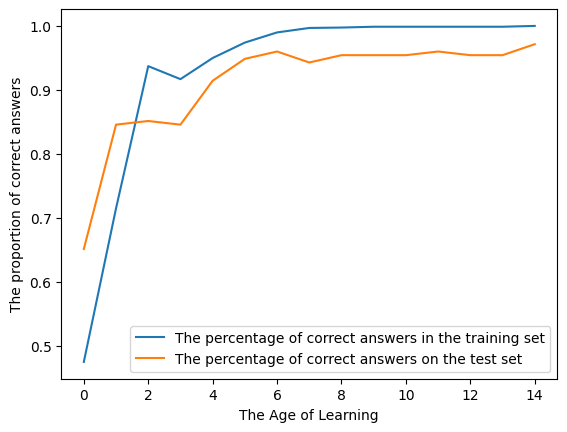

In [ ]:
plt.plot(history_cnn.history['accuracy'],
         label='The percentage of correct answers in the training set')
plt.plot(history_cnn.history['val_accuracy'],
         label='The percentage of correct answers on the test set')
plt.xlabel('The Age of Learning')
plt.ylabel('The proportion of correct answers')
plt.legend()
plt.show()

# Recurrent LSTM network

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max1))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(5, activation='softmax'))

model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs=15,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4464 - loss: 1.5966
Epoch 1: val_accuracy improved from -inf to 0.74286, saving model to best_model_lstm.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4537 - loss: 1.5958 - val_accuracy: 0.7429 - val_loss: 1.5498
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8181 - loss: 1.5243
Epoch 2: val_accuracy improved from 0.74286 to 0.78286, saving model to best_model_lstm.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8178 - loss: 1.5227 - val_accuracy: 0.7829 - val_loss: 1.4557
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8066 - loss: 1.4185
Epoch 3: val_accuracy did not improve from 0.78286
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8061 - loss: 1.4158 - val_accuracy: 0.7314 - val_loss: 1.3040
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6976 - loss: 1.2484
Epoch 4: val_accuracy did not improve from 0.78286
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6974 - loss: 1.2445 - val_accuracy: 0.7029 - val_loss: 1.0913
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7459 - loss: 1.0012
Epoch 5: val_accuracy did not improve from 0.78286
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7451 - loss: 0.9989 - val_accuracy: 0.7314 - val_loss: 0.8676
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8058 - loss: 0.7819
Epoch 6: val_accuracy improved from 0.78286 to 0.83429,

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8075 - loss: 0.7793 - val_accuracy: 0.8343 - val_loss: 0.6951
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9007 - loss: 0.5976
Epoch 7: val_accuracy improved from 0.83429 to 0.85714, saving model to best_model_lstm.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9010 - loss: 0.5960 - val_accuracy: 0.8571 - val_loss: 0.5870
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9184 - loss: 0.4878
Epoch 8: val_accuracy improved from 0.85714 to 0.89143, saving model to best_model_lstm.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9197 - loss: 0.4861 - val_accuracy: 0.8914 - val_loss: 0.5222
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9692 - loss: 0.3769
Epoch 9: val_accuracy improved from 0.89143 to 0.90857, saving model to best_model_lstm.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9688 - loss: 0.3772 - val_accuracy: 0.9086 - val_loss: 0.4524
Epoch 10/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9705 - loss: 0.3239
Epoch 10: val_accuracy improved from 0.90857 to 0.92000, saving model to best_model_lstm.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9707 - loss: 0.3231 - val_accuracy: 0.9200 - val_loss: 0.3984
Epoch 11/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9775 - loss: 0.2675
Epoch 11: val_accuracy did not improve from 0.92000
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9775 - loss: 0.2669 - val_accuracy: 0.9029 - val_loss: 0.3858
Epoch 12/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9700 - loss: 0.2486
Epoch 12: val_accuracy did not improve from 0.92000
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9699 - loss: 0.2481 - val_accuracy: 0.8971 - val_loss: 0.3609
Epoch 13/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9816 - loss: 0.2002
Epoch 13: val_accuracy did not improve from 0.92000
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9818 - loss: 0.1997 - val_accuracy: 0.9086 - val_loss: 0.3544
Epoch 14/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9870 - loss: 0.1681
Epoch 14: val_accuracy did not improve from 0.92

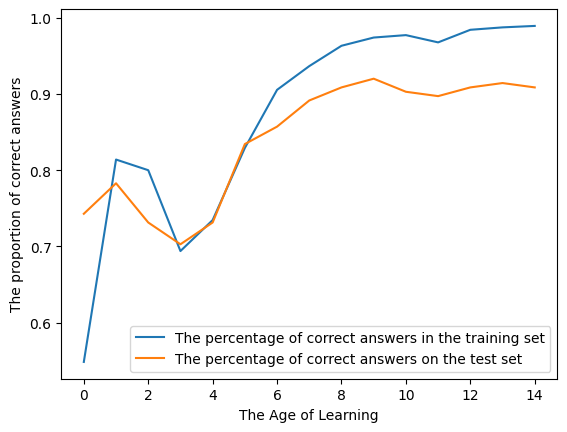

In [ ]:
plt.plot(history_lstm.history['accuracy'],
         label='The percentage of correct answers in the training set')
plt.plot(history_lstm.history['val_accuracy'],
         label='The percentage of correct answers on the test set')
plt.xlabel('The Age of Learning')
plt.ylabel('The proportion of correct answers')
plt.legend()
plt.show()

# Recurrent GRU network

In [ ]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max1))
model_gru.add(GRU(16))
model_gru.add(Dense(5, activation='softmax'))

model_gru.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_gru.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history_gru = model_gru.fit(x_train,
                              y_train,
                              epochs=15,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3686 - loss: 1.5972
Epoch 1: val_accuracy improved from -inf to 0.69714, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3763 - loss: 1.5964 - val_accuracy: 0.6971 - val_loss: 1.5478
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7758 - loss: 1.5249
Epoch 2: val_accuracy improved from 0.69714 to 0.73714, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7773 - loss: 1.5235 - val_accuracy: 0.7371 - val_loss: 1.4587
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8541 - loss: 1.4158
Epoch 3: val_accuracy improved from 0.73714 to 0.75429, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8537 - loss: 1.4138 - val_accuracy: 0.7543 - val_loss: 1.3243
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8534 - loss: 1.2619
Epoch 4: val_accuracy improved from 0.75429 to 0.76000, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8540 - loss: 1.2590 - val_accuracy: 0.7600 - val_loss: 1.1450
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8862 - loss: 1.0419
Epoch 5: val_accuracy improved from 0.76000 to 0.78286, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8846 - loss: 1.0402 - val_accuracy: 0.7829 - val_loss: 0.9464
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8729 - loss: 0.8362
Epoch 6: val_accuracy improved from 0.78286 to 0.82857, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8730 - loss: 0.8346 - val_accuracy: 0.8286 - val_loss: 0.7733
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8942 - loss: 0.6688
Epoch 7: val_accuracy improved from 0.82857 to 0.83429, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8941 - loss: 0.6668 - val_accuracy: 0.8343 - val_loss: 0.6380
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9123 - loss: 0.5108
Epoch 8: val_accuracy improved from 0.83429 to 0.85143, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9122 - loss: 0.5099 - val_accuracy: 0.8514 - val_loss: 0.5288
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9272 - loss: 0.4089
Epoch 9: val_accuracy improved from 0.85143 to 0.86857, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9278 - loss: 0.4072 - val_accuracy: 0.8686 - val_loss: 0.4486
Epoch 10/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9505 - loss: 0.3108
Epoch 10: val_accuracy improved from 0.86857 to 0.88571, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9511 - loss: 0.3099 - val_accuracy: 0.8857 - val_loss: 0.3959
Epoch 11/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9648 - loss: 0.2558
Epoch 11: val_accuracy improved from 0.88571 to 0.91429, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9652 - loss: 0.2546 - val_accuracy: 0.9143 - val_loss: 0.3605
Epoch 12/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9726 - loss: 0.2050
Epoch 12: val_accuracy did not improve from 0.91429
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9727 - loss: 0.2044 - val_accuracy: 0.9029 - val_loss: 0.3402
Epoch 13/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9740 - loss: 0.1751
Epoch 13: val_accuracy improved from 0.91429 to 0.92000, saving model to best_model_gru.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9742 - loss: 0.1744 - val_accuracy: 0.9200 - val_loss: 0.3191
Epoch 14/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9767 - loss: 0.1472
Epoch 14: val_accuracy did not improve from 0.92000
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9769 - loss: 0.1468 - val_accuracy: 0.9029 - val_loss: 0.3117
Epoch 15/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9762 - loss: 0.1332
Epoch 15: val_accuracy did not improve from 0.92000
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9765 - loss: 0.1325 - val_accuracy: 0.9200 - val_loss: 0.2952


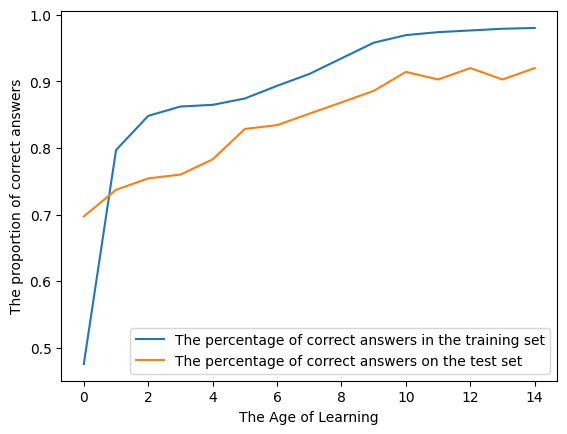

In [ ]:
plt.plot(history_gru.history['accuracy'],
         label='The percentage of correct answers in the training set')
plt.plot(history_gru.history['val_accuracy'],
         label='The percentage of correct answers on the test set')
plt.xlabel('The Age of Learning')
plt.ylabel('The proportion of correct answers')
plt.legend()
plt.show()

# Checking on the testing set

In [ ]:
test

,text,class
0,Ваше счастливое число на сегодня — 1⃣1⃣.1⃣1⃣\n...,1
1,"Снова — неочевидные факты, о которых невозможн...",0
2,"Кешбэк, который действительно работает на тебя...",3
3,Дарим 100 000₽ на роллы и выпрямитель Dyson!\n...,3
4,nan,0
...,...,...
745,🍣 Поздравляем с Днём Суши \n \nСегодня официал...,1
746,"Кешбэк, который действительно работает на тебя...",3
747,"Друзья, подводим итоги конкурса ""Самый активны...",2
748,"ТЕПЛИЦЫ, ПРИСТРОЕННЫЕ К ДОМУ \n \nПри проектир...",0


In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['text'])

x_test = pad_sequences(test_sequences, maxlen=max1)
x_test

array([[   0,    0,    0, ..., 1433,   13,   39],
       [   0,    0,    0, ...,  506,  469,  653],
       [   0,    0,    0, ...,   18,  705,  736],
       ...,
       [   0,    0,    0, ..., 1997,    3, 2072],
       [   0,    0,    0, ...,  124, 2174, 4907],
       [   0,    0,    0, ...,   16,    4,  402]], dtype=int32)

In [ ]:
y_test

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

# We evaluate the quality of the networks on the test set

One-dimensional convolutional network

In [ ]:
model_cnn.load_weights(model_cnn_save_path)
model_cnn.evaluate(x_test, y_test, verbose=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9448 - loss: 0.1314


[0.1272038221359253, 0.9546666741371155]

Recurrent LSTM Network

In [ ]:
model_cnn.load_weights(model_cnn_save_path)
model_lstm.evaluate(x_test, y_test, verbose=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9195 - loss: 0.2860


[0.29285138845443726, 0.9266666769981384]

The GRU Recurrent Network

In [ ]:
model_gru.load_weights(model_gru_save_path)
model_gru.evaluate(x_test, y_test, verbose=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.8970 - loss: 0.3685


[0.3457617461681366, 0.909333348274231]

# Optimization of neural network hyperparameters using Keras Tuner

In [ ]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from google.colab import files
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import numpy as np

/tmp/ipython-input-2378211027.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization


In [ ]:
def build_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu'])
    model.add(Dense(units=hp.Int('units_input',    # A fully connected layer with a different number of neurons
                                   min_value=512,    # the minimum number of neurons is 128
                                   max_value=1024,   # the maximum number is 1024
                                   step=32),
                    input_dim=784,
                    activation=activation_choice))
    model.add(Dense(units=hp.Int('units_hidden',
                                   min_value=128,
                                   max_value=600,
                                   step=32),
                    activation=activation_choice))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,                 # model creation function
    objective='val_accuracy',    # metric to optimize -
                                 # the proportion of correct answers in the verification dataset
    max_trials=80,               # maximum number of training runs
    directory='test_directory'   # the directory where the trained networks are saved
    )
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu', 'selu'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 600, 'step': 32, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'SGD'], 'ordered': False}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
